# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)
from PIL import Image, ImageDraw
from matplotlib import cm
import torchvision.transforms.functional as tF

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)

Bounding box [x_min, y_min, x_max, y_max]: [571.89217841 547.14270504 901.62193347 509.08239738]


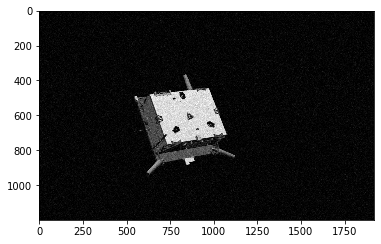

In [4]:
i = 895
img, label, K = sample_dataset[i]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [5]:
class JointRescrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        target_q = target[:4]
        target_r = target[4:7]
        target_db = target[7:11] 
        target_bb = target[11:]

        sz = self.size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        self.cropSize = int(fS * max(dx, dy))
        if self.cropSize > min(img.size):
            self.cropSize = min(img.size)
#         print("cropSize: ", cropSize)
        
        # Crop Image
        self.cx = sum(x)/len(x)
        self.cy = sum(y)/len(y)
        top = self.cy - self.cropSize/2
        left = self.cx - self.cropSize/2
        img = tF.crop(img, top, left, self.cropSize, self.cropSize)
        
        # Crop translation of points
        xtarget = [self.cropSize/2 + (i - self.cx) for i in x]
        ytarget = [self.cropSize/2 + (i - self.cy) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        target_bb = np.array(target_bb)
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]

        # Update db from bb
        xa = target_bb[0::2]
        ya = target_bb[1::2]
        target_db = [min(xa), min(ya), max(xa), max(ya)]
        
        target = np.concatenate((target_q, target_r, target_db, target_bb))

        return img, target

In [6]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(target)

In [7]:
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [8]:
class JointNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, img, target):
        # Expects img to be a tensor
        timg = tF.normalize(img, self.mean, self.std)
        return (timg, target)

In [9]:
# Transforms
train_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
#     JointNormalize([0.5], [0.5])
])

sanity_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

In [10]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=1000, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

[129.39001083162302, 106.49745510471199]

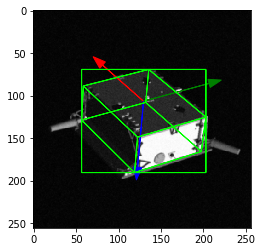

In [11]:
# TEST
sample, target, K = training_dataset[17]
sample2, target2, K2 = training_dataset[80]
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(sample), target.numpy())
image2, label2 = JointRescrop((256, 256))(tF.to_pil_image(sample2), target2.numpy())
training_dataset.visualize(image2, label2, K2, factor=0.6, bbox=True, dbox=True)

In [12]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [13]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False, drop_last=True) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False, drop_last=True)

## Network implementations
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons.

Mango performs direct regression of both translation and orientation (quaternions and EA are used). A 2D bounding box is used to contrain the regression of the translation (donkey tail analogy). Considering it is only doing regression, Mango's results are pretty good, but not great. There's evidence that what the network learned generalizes poorly to certain orientations of the satellite. The Mango implementation serves as our **baseline**.

Tango still regresses the translation but learns the correct orientation via classification (based on the discretization of the domain of each Euler angle). Tango is more **experimental**.

In [14]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [15]:
class MangoNet(nn.Module):
    def __init__(self, criterion=None):
        super(MangoNet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        self.t_branch = nn.Sequential(nn.Linear(3*3*1024, 1024),
#                                       nn.BatchNorm1d(1024),
                                      nn.ReLU(inplace=True),
#                                       nn.Dropout(),
                                      nn.Linear(1024, 3))



        # Attitude branch: q = [q0, q1, q2, q3]
        self.att_branch = nn.Sequential(nn.Linear(3*3*1024, 4096),
                                        nn.BatchNorm1d(4096),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(4096, 500),
                                        nn.BatchNorm1d(500),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(500, 3),
                                        )
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # t regression
        x_t = self.t_branch(x_t)

        # q regression
        x_att = np.pi*torch.tanh(self.att_branch(x_att))



        return x_t, x_att
#         return x_att


### Training

In [16]:
OVERFIT=False
TRAINING=True
BETA=1
if OVERFIT:
    overfit_net = MangoNet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [17]:
def get_of_optimizer(net):
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.00001,
                                momentum=0.9)
    return optimizer

In [18]:
def dcm_to_q(dcm):
    q0 = -0.5*torch.sqrt(dcm[:, [0], [0]]+dcm[:, [1], [1]]+dcm[:, [2], [2]]+1)
    q1 = (dcm[:, [1], [2]]-dcm[:, [2], [1]])/(4*q0)
    q2 = (dcm[:, [2], [0]]-dcm[:, [0], [2]])/(4*q0)
    q3 = (dcm[:, [0], [1]]-dcm[:, [1], [0]])/(4*q0)
    return torch.cat((q0, q1, q2, q3), 1)

In [19]:
def quat2dcm(q):
    dcm = torch.zeros(q.shape[0],3,3).cuda()
    q0 = q[:, [0]]
    q1 = q[:, [1]]
    q2 = q[:, [2]]
    q3 = q[:, [3]]
    
    dcm[:, [0], [0]] = 2 * q0 ** 2 - 1 + 2 * q1 ** 2
    dcm[:, [1], [1]] = 2 * q0 ** 2 - 1 + 2 * q2 ** 2
    dcm[:, [2], [2]] = 2 * q0 ** 2 - 1 + 2 * q3 ** 2

    dcm[:, [0], [1]] = 2 * q1 * q2 + 2 * q0 * q3
    dcm[:, [0], [2]] = 2 * q1 * q3 - 2 * q0 * q2

    dcm[:, [1], [0]] = 2 * q1 * q2 - 2 * q0 * q3
    dcm[:, [1], [2]] = 2 * q2 * q3 + 2 * q0 * q1

    dcm[:, [2], [0]] = 2 * q1 * q3 + 2 * q0 * q2
    dcm[:, [2], [1]] = 2 * q2 * q3 - 2 * q0 * q1
    
    return dcm

In [20]:
def skew_symmetric(prv):
    """
    Transforms prv output by network into skew symmetric matrix
    """
    ssm = torch.zeros(prv.shape[0],3,3).cuda()
    ssm[:, [0], [1]] = -prv[:, [2]]
    ssm[:, [0], [2]] = prv[:, [1]]
    ssm[:, [1], [0]] = prv[:, [2]]
    ssm[:, [1], [2]] = -prv[:, [0]]
    ssm[:, [2], [0]] = -prv[:, [1]]
    ssm[:, [2], [1]] = prv[:, [0]]
    
    return ssm

In [21]:
def prv_loss1(q_gt, prv_pred):
    ss_prv_pred = skew_symmetric(prv_pred)
    R_pred = torch.matrix_exp(ss_prv_pred)
    q_pred = dcm_to_q(R_pred)
    print(q_pred.shape, q_gt.shape)
    loss = 1 - (q_gt.T@q_pred)**2
    return loss.mean()
    

In [22]:
def prv_loss2(q_gt, prv_pred):
    """
    Loss function for Axis-angle attitude regression
        q_gt: ground truth quaternion(s), (bs, 1x4)
        prv_pred: prv output, (bs, 1x3)
    """
    R = quat2dcm(q_gt)
    ss_prv_pred = skew_symmetric(prv_pred)
    R_pred = torch.matrix_exp(ss_prv_pred)
    loss = torch.acos((torch.diagonal(R.transpose(1, 2)@R_pred, dim1=-2, dim2=-1).sum(-1) - 1)/2)
    return loss.mean()

In [23]:
def translation_loss2(t_gt, t_pred, bbox, K):
    # WIP: Donkey Tail Hypothesis --> regress [du, dv, tz]
    u = (bbox[:, [0]] + bbox[:, [2]]) / 2.0
    v = (bbox[:, [1]] + bbox[:, [3]]) / 2.0
    # print(u, v)
    cx = K[:, [0], [2]]
    cy = K[:, [1], [2]]
    fx = K[:, [0], [0]]
    fy = K[:, [1], [1]]
    # Calculate true deviation from bbox center
    du = fx*t_gt[:, [0]] - u + cx*t_gt[:, [2]]
    dv = fy*t_gt[:, [1]] - v + cy*t_gt[:, [2]]
#     du = fx*t_gt[:, [0]]/t_gt[:, [2]] - u + cx
#     dv = fy*t_gt[:, [1]]/t_gt[:, [2]] - v + cy
    gt = torch.cat((du.float(), dv.float(), t_gt[:, [2]]), -1)
    return torch.mean(torch.norm((gt - t_pred)/torch.norm(gt)))

In [24]:
def translation_loss(t_gt, t_pred):
    return torch.mean(torch.norm((t_gt - t_pred)/torch.norm(t_gt)))

In [25]:
def attitude_loss(att_gt, att_pred):
    bs = att_gt.shape[0]
    att_pred = F.normalize(att_pred, p=2, dim=1)
    prod = torch.bmm(att_gt.view(bs, 1, 4), att_pred.view(bs, 4, 1)).reshape(bs, 1)
    loss = 1 - prod ** 2
    # sigma = att_gt[0][1:4] / (1 + att_gt[0][0])
    # s2 = torch.norm(sigma) ** 2
    # if s2 > 1.0:
    #     sigma /= -s2
    # return torch.sum(torch.norm(sigma[None] - att_pred, p=2))
    return torch.mean(loss)


In [26]:
def train(train_loader, net, optimizer_t, optimizer_a, loss_graph):
    epoch_loss = 0
    epoch_loss_t = 0
    epoch_loss_att = 0

    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        optimizer_t.zero_grad()
        optimizer_a.zero_grad()
        t, att = net(inputs)
        # t = net(inputs)
        # att = net(inputs)

#         L_t = translation_loss(t_gt, t)
        L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
        L_att = attitude_loss(att_gt, att)
        total_loss = L_t + BETA*L_att  #+ (torch.abs(torch.mean(1 - torch.norm(att))))
        loss_graph[0].append(total_loss.item())
        loss_graph[1].append(L_t.item())
        loss_graph[2].append(L_att.item())
        epoch_loss_t += L_t.item()
        epoch_loss_att += L_att.item()

        # loss_graph.append(total_loss.item())
        total_loss.backward()

        optimizer_t.step()
        optimizer_a.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader), epoch_loss_t / len(train_loader), epoch_loss_att / len(train_loader)

In [27]:
def train4(train_loader, net, optimizer_t, optimizer_a, epoch, loss_graph):
    epoch_loss = 0
    epoch_loss_t = 0
    epoch_loss_att = 0
    
    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        optimizer_t.zero_grad()
        optimizer_a.zero_grad()

        t, att = net(inputs)
        L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
        L_att = prv_loss2(att_gt, att)
        total_loss = L_t + L_att
            
        loss_graph[0].append(total_loss.item())
        loss_graph[1].append(L_t.item())
        loss_graph[2].append(L_att.item())
        epoch_loss_t += L_t.item()
        epoch_loss_att += L_att.item()

        total_loss.backward()
        optimizer_t.step()
        optimizer_a.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader), epoch_loss_t / len(train_loader), epoch_loss_att / len(train_loader)

In [28]:
EPOQUE = 120

if OVERFIT:
    # Training mode
    overfit_net.train()

    optimizer = get_of_optimizer(overfit_net)

    print("Starting Training...")

    loss_graph = [[],[],[],[],[]]

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    for e in range(EPOQUE):
        loss = train4(sanity_loader, overfit_net, optimizer, e, loss_graph)
#         scheduler.step()
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph[0], label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

### Evaluation

In [29]:
if OVERFIT:
    img1, label1, K1 = sanity_dataset[0]

    if USE_GPU:
        img1 = img1.cuda()
    prv_out = overfit_net.forward(img1[None])
    R_pred = torch.matrix_exp(skew_symmetric(prv_out))
    att_out = dcm_to_q(R_pred)
    att_out = att_out.detach().cpu().numpy()[0]
    img1 = img1.cpu()

    # Plotting groundtruth
    size = (256, 256)
    vectorScaleFactor = 4
    image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())

    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    true_origin = training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

    fig.add_subplot(1, 2, 2)

    # Standard
    # att_out /= np.linalg.norm(att_out)
    origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, label1[4:7])), K1, factor=0.6, bbox=True)
    # origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.6, bbox=True)

    # Prediction errors
    # Difference in body frame origin (in image plane)
    t_error = np.linalg.norm(np.array(true_origin) - np.array(origin))

    # Quaternion error
    q_error = 1-np.dot(label1[:4], att_out)**2
    # plt.title("$t_e = {{{}}}$ \n $q_e = {{{}}}$".format(t_error, q_error))
    print("Translation error: {}".format(t_error))
    print("Orientation error: {}".format(q_error))


## Training
Training on entire dataset

In [30]:
# NOTE: lr=0.1 was used for origin regression from bbox center
def get_optimizer(net, lr):
    # optimizer = torch.optim.Adam(net.parameters())
#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=lr,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

Starting Training...


<IPython.core.display.Javascript object>


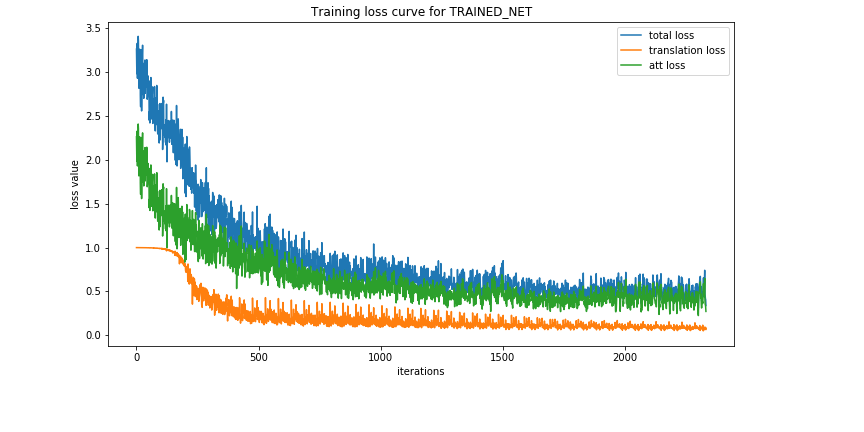

Epoch: 0 Loss: (2.9716099163271346, 0.9991852472413261, 1.9724246758335042)
Epoch: 1 Loss: (2.531461733692097, 0.9938753809569016, 1.5375863516105797)
Epoch: 2 Loss: (2.3226400366369284, 0.9679899395636793, 1.3546501128178723)
Epoch: 3 Loss: (2.0778935360458664, 0.8464985028752741, 1.231395034295208)
Epoch: 4 Loss: (1.689187153330389, 0.5579349646028483, 1.1312521943506204)
Epoch: 5 Loss: (1.4639931152451713, 0.42908044468681766, 1.0349126750568174)
Epoch: 6 Loss: (1.3651406247660798, 0.344063013510884, 1.0210776205332774)
Epoch: 7 Loss: (1.1854509250173029, 0.280259371647295, 0.9051915587119337)
Epoch: 8 Loss: (1.0989074954446756, 0.2353627676109098, 0.8635447238976101)
Epoch: 9 Loss: (1.0384211337791298, 0.22000007162678917, 0.8184210646827266)
Epoch: 10 Loss: (1.024041860733392, 0.21093139164852645, 0.8131104651487099)
Epoch: 11 Loss: (0.9140789452588783, 0.19659654486854122, 0.7174823981411053)
Epoch: 12 Loss: (0.8583520178524953, 0.18598702409357395, 0.6723649985385391)
Epoch: 13 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


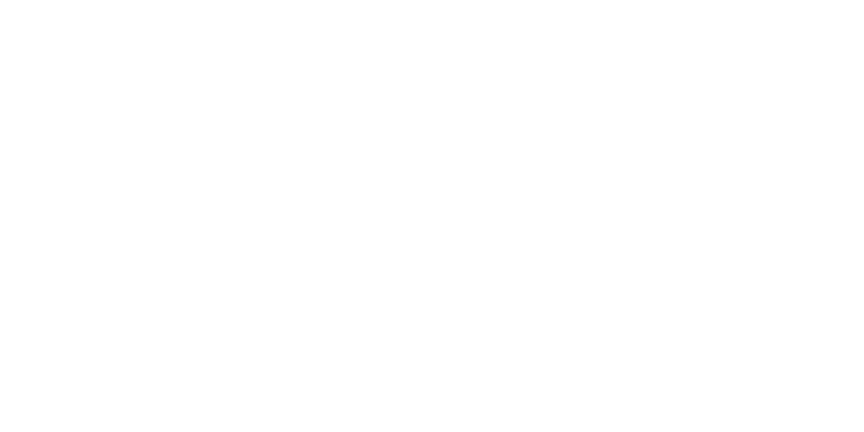

In [31]:
%%time
%matplotlib notebook
if TRAINING:
    EPOCH = 100
    trained_net = MangoNet()

    if USE_GPU:
        trained_net = trained_net.cuda()

    # Optimizer
    optimizer_t = get_optimizer(trained_net.t_branch, 0.1)
    optimizer_a = get_optimizer(trained_net, 0.0001)
#     optimizer_a = torch.optim.Adam(list(trained_net.parameters()), lr = 3e-3)
#     optimizer = torch.optim.SGD(params=param_list,
#                                 lr=0.001,
#                                 weight_decay=0.0001,
#                                 momentum=0.9)
    
    # Learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer_t, step_size=10, gamma=0.1)
    
    # Switch to train mode
    trained_net.train()

    print("Starting Training...")

    loss_graph = [[],[],[],[],[]]

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOCH):            
        loss = train4(train_loader, trained_net, optimizer_t, optimizer_a, e, loss_graph)
#         scheduler.step()
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for TRAINED_NET')
        ax.plot(loss_graph[0], label='total loss')
        ax.plot(loss_graph[1], label='translation loss')
        ax.plot(loss_graph[2], label='att loss')

        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))
%matplotlib inline

## Testing

In [32]:
def origin_reg_conversion(label, K, t_out):
    u = (label[4:11][0] + label[4:11][2]) / 2.0
    v = (label[4:11][1] + label[4:11][3]) / 2.0
    cx = K[0, 2]
    cy = K[1, 2]
    fx = K[0, 0]
    fy = K[1, 1]
    tx = (u + t_out[0] - cx*t_out[2])/fx
    ty = (v + t_out[1] - cy*t_out[2])/fy
#     tx = t_out[2]/fx*(u + t_out[0]-cx)
#     ty = t_out[2]/fy*(v + t_out[1]-cy)
    return np.array([tx, ty, t_out[2]])


In [35]:
def evaluate(val_loader, net):
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target, K = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                K = K.cuda()

            att_gt = target[:, :4].float()
            t_gt = target[:, 4:7].float()
            
            t, att = net(inputs)
            
            L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
            L_att = prv_loss2(att_gt, att)
            loss = L_att + L_t
            total_loss += loss.item()

    return total_loss / len(val_loader)#, t1_loss / len(val_loader), t2_loss / len(val_loader), t3_loss / len(val_loader)

In [36]:
# Switch to evaluation mode
# TODO: plot test loss
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 1.667518563469251


Translation error: 14.007809278636625
Orientation error: 0.0253447500687084


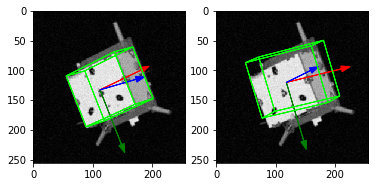

In [43]:
# Evaluation
%matplotlib inline
idx = 5
img1, label1, K1 = test_dataset[idx]

if USE_GPU:
    img1 = img1.cuda()
# t1_out, t2_out, t3_out = trained_net.forward(img1[None])
t_out, prv_out = trained_net.forward(img1[None])
R_pred = torch.matrix_exp(skew_symmetric(prv_out))
att_out = dcm_to_q(R_pred)
att_out = att_out.detach().cpu().numpy()[0]
t_out = t_out.detach().cpu().numpy()[0]
img1 = img1.cpu()

# Plotting groundtruth
size = (256, 256)
vectorScaleFactor = 4
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())

fig = plt.figure()
fig.add_subplot(1, 2, 1)
true_origin = training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

fig.add_subplot(1, 2, 2)

# MRP conversion
# new_att = mrp_to_q(att_out)
# test_dataset.dataset.visualize(image1, np.concatenate((new_att, t_out)), bbox=True)

# Origin regression from bbox center
# att_out /= np.linalg.norm(att_out)
t_pred_new = origin_reg_conversion(label1, K1, t_out)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((label1[:4], t_pred_new)), K1, factor=0.6, bbox=True)
origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_pred_new)), K1, factor=0.6, bbox=True)

# Standard
# att_out /= np.linalg.norm(att_out)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, label1[4:7])), K1, factor=0.6, bbox=True)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.6, bbox=True)


# Prediction errors
# Difference in body frame origin (in image plane)
t_error = np.linalg.norm(np.array(true_origin) - np.array(origin))

# Quaternion error
q_error = 1-np.dot(label1[:4], att_out)**2
# plt.title("$t_e = {{{}}}$ \n $q_e = {{{}}}$".format(t_error, q_error))
print("Translation error: {}".format(t_error))
print("Orientation error: {}".format(q_error))

In [44]:
np.linalg.norm(att_out)

1.0